In [1]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.getcwd()

'/home/adwai/BTP/genre'

In [2]:
import pickle
import torch
import utils
import data.utils as dutils
import matplotlib.pyplot as plt
import numpy as np

import recourse.utils as rutils
from sklearn.neighbors import LocalOutlierFactor
from recourse.genre import GenRe
from recourse.genre import OldFlexibleGenRe

In [3]:
import models.binnedpm as bpm

In [4]:
def get_cost(src_X, tgt_X, immutable_mask, cost_weights=[0.5, 0.5], p=2):
    cost_weights = torch.tensor(cost_weights, device=src_X.device, dtype=src_X.dtype)
    cost_weights /= torch.sum(cost_weights)
    diff = (src_X - tgt_X).abs()  # [N, D]
    D = ((diff ** p) * cost_weights).sum(dim=-1) ** (1 / p)  # [N]
    cost = torch.mean(D)
    return cost

def get_LOF(tgt_X, ann_clf, gamma=0.7):
    pred = ((ann_clf(tgt_X)>gamma)*1.0)
    LOF = torch.mean(pred)
    return LOF

def get_val(tgt_X, ann_clf):
    pred = ((ann_clf(tgt_X)>0.5)*1.0)
    val = torch.mean(pred)
    return val

def get_score(src_X, tgt_X, immutable_mask, ann_clf, cost_weights=[0.5, 0.5], lambda_=50.0, p=2, gamma=0.7):
    cost = get_cost(src_X, tgt_X, immutable_mask, cost_weights=cost_weights, p=p)
    LOF = get_LOF(tgt_X, ann_clf, gamma=gamma)
    val = get_val(tgt_X, ann_clf)
    print("cost: ", round(cost.item(), 3))
    print("val: ", round(val.item(), 3))
    print("LOF: ", round(LOF.item(), 3))
    score = val + LOF - cost/p
    print("Score: ", round(score.item(), 3))
    return score

In [5]:
exp_config = utils.load_config('results/exp1_config.yaml')

In [6]:
cost_weights = [0.5, 0.5]
cost_weights_str = f"{cost_weights[0]:.1f}_{cost_weights[1]:.1f}"
cost_weights_1 = [0.9, 0.1] #[0.99, 0.01] #[0.9, 0.1] #[1.0, 0.0]
cost_weights_str_1 = f"{cost_weights_1[0]:.1f}_{cost_weights_1[1]:.1f}"
# cost_weights_str_1 = f"{cost_weights_1[0]:.2f}_{cost_weights_1[1]:.2f}"
cost_weights_2 = [0.1, 0.9] #[0.01, 0.99] #[0.1, 0.9] #[0.0, 1.0]
cost_weights_str_2 = f"{cost_weights_2[0]:.1f}_{cost_weights_2[1]:.1f}"
# cost_weights_str_2 = f"{cost_weights_2[0]:.2f}_{cost_weights_2[1]:.2f}"

----------------------------- Executing for Dataset circles -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/circles/ann_rf_tt_mm_10_8
torch.Size([150, 2])
150
cost:  0.088
val:  1.0
LOF:  1.0
Score:  1.912


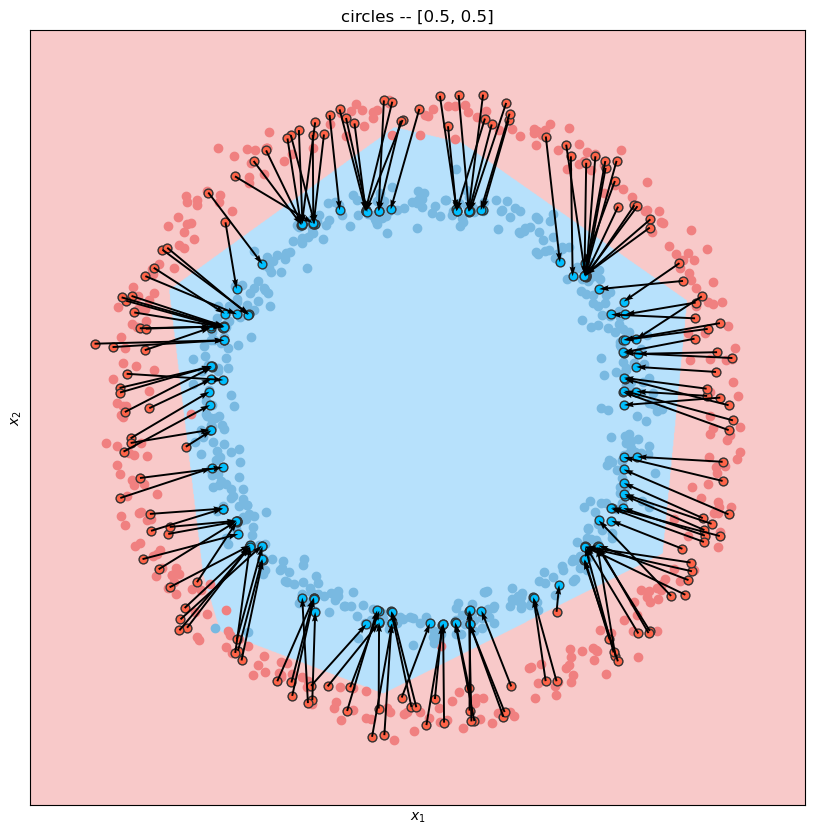

In [7]:
for DATASET_STR in ['circles']: #['squares']: #['compas-all','heloc', 'adult-all']:
    for train_lambda in [75.0]: #[20.0]: #[10.0]: #[5.0]:
        print(f"----------------------------- Executing for Dataset {DATASET_STR} -----------------------------")
        YSTAR = 1.0
        DEVICE = 'cpu' #'cuda:0'
        TRAIN_P = 1
        SEED = 42

        utils.set_seed(SEED)

        # load dataset
        train_y,train_X,test_y,test_X, cat_mask, immutable_mask = dutils.load_dataset(DATASET_STR, ret_tensor=True, min_max=True, ret_masks=True)
        INPUT_SHAPE = train_X.shape[1]

        LABEL_PATH =  utils.get_rf_folder(DATASET_STR,True,True)
        train_y,train_X,test_y,test_X = dutils.load_dataset(DATASET_STR, cust_labels_path=LABEL_PATH, ret_tensor=True, min_max=True)
        INPUT_SHAPE = train_X.shape[1]
        ann_clf, ann_folder = utils.load_ann(INPUT_SHAPE=INPUT_SHAPE,DATASET_STR=DATASET_STR, 
                                                LABEL_SRC='rf',**exp_config['common'],**exp_config['ann'][DATASET_STR])

        # heloc, compas-all, adult-all
        # pair_model = bpm.PairedTransformerBinned(n_bins=50,
        #                                     num_inputs=INPUT_SHAPE,
        #                                     num_labels=1,
        #                                     num_encoder_layers=16,
        #                                     num_decoder_layers=16,
        #                                     emb_size=32,
        #                                     nhead=8,
        #                                     dim_feedforward = 32,
        #                                     dropout= 0.1).to(DEVICE)
        pair_model = bpm.PairedTransformerBinned(
                                                        n_bins=50,                # Keep as is — fine resolution for continuous features
                                                        num_inputs=2,             # Since your data is 2D
                                                        num_labels=1,             # Binary classification
                                                        num_encoder_layers=2,     # Only 2 encoder layers are sufficient
                                                        num_decoder_layers=2,     # 2 decoder layers for similar capacity
                                                        emb_size=16,              # Smaller embedding (reduces overfitting)
                                                        nhead=2,                  # 2 heads => each head gets 8-dim subspace
                                                        dim_feedforward=64,       # Slightly higher than emb_size, stable transformer FF
                                                        dropout=0.1               # Regularization, fine for small data
                                                    ).to(DEVICE)

        # PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'
        PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}_{cost_weights_str}.pth'

        state = torch.load(PM_STATE_PATH, map_location='cpu')
        pair_model.load_state_dict(state["state_dict"])
        pair_model = pair_model.to(DEVICE)
        pair_model.eval()

        loss_log = {k:state[k] for k in ('train','val','test')}
        
        # fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10, 20))
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 20))
        # fig.set_size_inches(10, 20)
        # utils.plot_curves(ax[0],loss_log)

        best_epoch = state['epoch']
        # ax[0].set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
        

        ann_clf = ann_clf.to(DEVICE)


        # # get negative instances
        xf_r = rutils.get_neg_inst(ann_clf,train_X,YSTAR,sample=150)
        xf_r = xf_r.to(DEVICE)

        # wf random weights between 0 and 1 , with same shape as xf_r
        # wf weights 1,0 for first feature and 0 for rest of the features


        # wf = torch.rand([xf_r.shape[0],xf_r.shape[1]], device=DEVICE)
        # wf[:,0]=0.0
        # wf[:,1]=1.0
        
        # wf = torch.rand([xf_r.shape[0],xf_r[0].shape], device=DEVICE)
        # print(wf)
        # broadcast to match the shape of xf_r
        # wf = wf.unsqueeze(1).repeat(1, xf_r.shape[1])
        print(xf_r.shape)
        # print(wf.shape)

        # experiment_name = f'paper_experiments'
        # common_dir = f"./results/{experiment_name}/{DATASET_STR}"
        # with open(f"{common_dir}/xf_r", "rb") as fp:
        #     xf_r = pickle.load(fp).cpu()
        # xf_r = xf_r.to(DEVICE)
        # xf_r = torch.tensor([[0.25,0.75],[0.25,0.25],[0.75,0.25],[0.75,0.75]], device=DEVICE)
        # xf_r = torch.tensor([[0.0,0.5],[0.5,1.0],[0.5,0],[0,1]], device=DEVICE)
        # xf_r = torch.tensor([[0.0,0.4],[0.25,0.8],[0.3,0.9],[0.4,1.0]], device=DEVICE)

        print(len(xf_r))
        
        rec_module = GenRe(pair_model=pair_model, temp=10, sigma=0.001, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
        sample_xcf = rec_module(xf_r)

        final_score = get_score(xf_r, sample_xcf, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P, gamma=0.7)

        # print(sample_xcf)
        utils.viz_clf(ax,ann_clf,train_X,train_y,hard=True)
        utils.scatter2d(ax,train_X,train_y,data_name='training data', s=20, show_axis_name=False)
        utils.plot_pairs(ax,xf_r,sample_xcf,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)
        ax.set_title(f"{DATASET_STR} -- {str(cost_weights)}")
        plt.savefig(f"plots_{DATASET_STR}_{cost_weights_str}.png")
        plt.show()

----------------------------- Executing for Dataset circles -----------------------------
[INFO] loaded ann model from /home/adwai/BTP/genre/saved_models/classifiers/circles/ann_rf_tt_mm_10_8
./saved_models/genre/circles_gamma0.7/state_75.0_0.9_0.1.pth
cost:  0.11
val:  1.0
LOF:  1.0
Score:  1.89


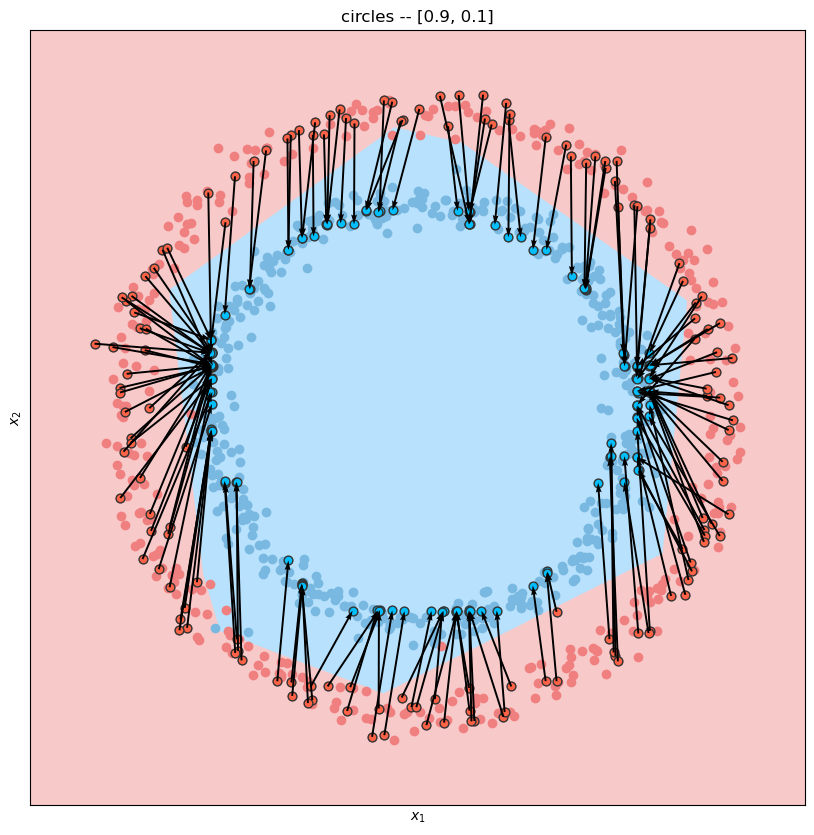

./saved_models/genre/circles_gamma0.7/state_75.0_0.1_0.9.pth
cost:  0.109
val:  1.0
LOF:  1.0
Score:  1.891


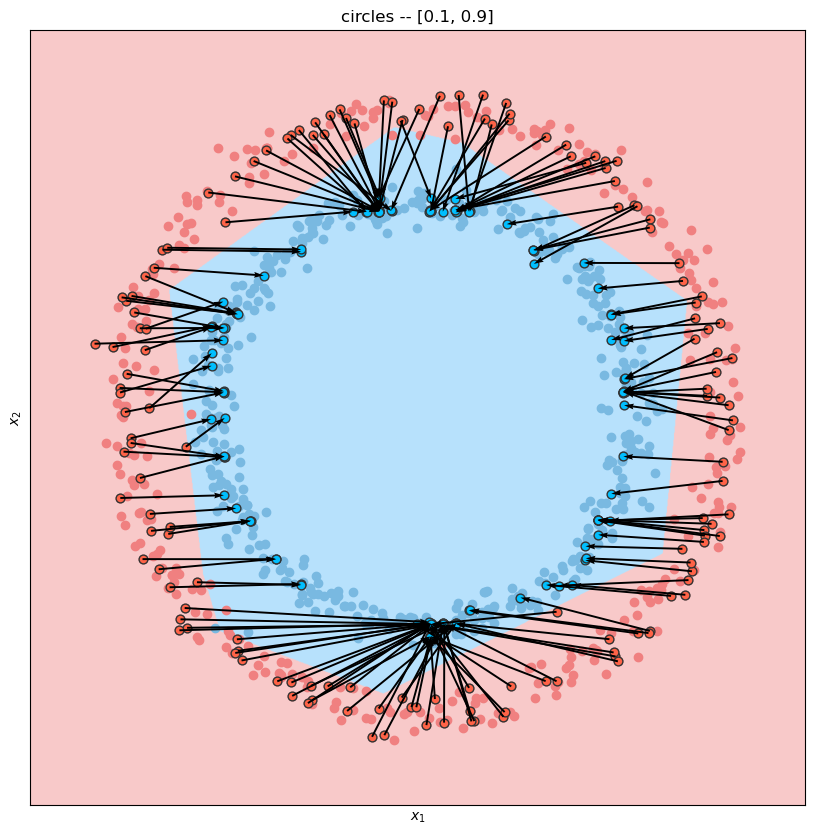

In [8]:
for DATASET_STR in ['circles']: #['squares']: #['compas-all','heloc', 'adult-all']:
    for train_lambda in [75.0]: #[10.0]: #[5.0]:
        print(f"----------------------------- Executing for Dataset {DATASET_STR} -----------------------------")
        YSTAR = 1.0
        DEVICE = 'cpu' #'cuda:0'
        TRAIN_P = 1
        SEED = 42

        utils.set_seed(SEED)

        # load dataset
        train_y,train_X,test_y,test_X, cat_mask, immutable_mask = dutils.load_dataset(DATASET_STR, ret_tensor=True, min_max=True, ret_masks=True)
        INPUT_SHAPE = train_X.shape[1]

        LABEL_PATH =  utils.get_rf_folder(DATASET_STR,True,True)
        train_y,train_X,test_y,test_X = dutils.load_dataset(DATASET_STR, cust_labels_path=LABEL_PATH, ret_tensor=True, min_max=True)
        INPUT_SHAPE = train_X.shape[1]
        ann_clf, ann_folder = utils.load_ann(INPUT_SHAPE=INPUT_SHAPE,DATASET_STR=DATASET_STR, 
                                                LABEL_SRC='rf',**exp_config['common'],**exp_config['ann'][DATASET_STR])

        # heloc, compas-all, adult-all
        # pair_model = bpm.PairedTransformerBinned(n_bins=50,
        #                                     num_inputs=INPUT_SHAPE,
        #                                     num_labels=1,
        #                                     num_encoder_layers=16,
        #                                     num_decoder_layers=16,
        #                                     emb_size=32,
        #                                     nhead=8,
        #                                     dim_feedforward = 32,
        #                                     dropout= 0.1).to(DEVICE)
        pair_model_1 = bpm.PairedTransformerBinned(
                                                        n_bins=50,                # Keep as is — fine resolution for continuous features
                                                        num_inputs=2,             # Since your data is 2D
                                                        num_labels=1,             # Binary classification
                                                        num_encoder_layers=2,     # Only 2 encoder layers are sufficient
                                                        num_decoder_layers=2,     # 2 decoder layers for similar capacity
                                                        emb_size=16,              # Smaller embedding (reduces overfitting)
                                                        nhead=2,                  # 2 heads => each head gets 8-dim subspace
                                                        dim_feedforward=64,       # Slightly higher than emb_size, stable transformer FF
                                                        dropout=0.1               # Regularization, fine for small data
                                                    ).to(DEVICE)

        # PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'
        PM_STATE_PATH_1  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}_{cost_weights_str_1}.pth'
        print(PM_STATE_PATH_1)

        state_1 = torch.load(PM_STATE_PATH_1, map_location='cpu')
        pair_model_1.load_state_dict(state_1["state_dict"])
        pair_model_1 = pair_model_1.to(DEVICE)
        pair_model_1.eval()

        loss_log = {k:state_1[k] for k in ('train','val','test')}
        
        # fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(10, 20))
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 20))
        # fig.set_size_inches(10, 20)
        # utils.plot_curves(ax[0],loss_log)

        best_epoch = state_1['epoch']
        # ax[0].set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
        

        ann_clf = ann_clf.to(DEVICE)
        # xf_r = rutils.get_neg_inst(ann_clf,train_X,YSTAR,sample=150)
        # xf_r = xf_r.to(DEVICE)
        # print(xf_r.shape)
        # print(len(xf_r))
        
        rec_module_1 = GenRe(pair_model=pair_model_1, temp=10, sigma=0.001, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
        sample_xcf_1 = rec_module_1(xf_r)

        final_score = get_score(xf_r, sample_xcf_1, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P, gamma=0.7)

        # print(sample_xcf)
        utils.viz_clf(ax,ann_clf,train_X,train_y,hard=True)
        utils.scatter2d(ax,train_X,train_y,data_name='training data', s=20, show_axis_name=False)
        utils.plot_pairs(ax,xf_r,sample_xcf_1,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)
        # plt.savefig("plots_1.png")
        ax.set_title(f"{DATASET_STR} -- {str(cost_weights_1)}")
        plt.savefig(f"plots_{DATASET_STR}_{cost_weights_str_1}.png")
        plt.show()

        pair_model_2 = bpm.PairedTransformerBinned(
                                                        n_bins=50,                # Keep as is — fine resolution for continuous features
                                                        num_inputs=2,             # Since your data is 2D
                                                        num_labels=1,             # Binary classification
                                                        num_encoder_layers=2,     # Only 2 encoder layers are sufficient
                                                        num_decoder_layers=2,     # 2 decoder layers for similar capacity
                                                        emb_size=16,              # Smaller embedding (reduces overfitting)
                                                        nhead=2,                  # 2 heads => each head gets 8-dim subspace
                                                        dim_feedforward=64,       # Slightly higher than emb_size, stable transformer FF
                                                        dropout=0.1               # Regularization, fine for small data
                                                    ).to(DEVICE)

        PM_STATE_PATH_2  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}_{cost_weights_str_2}.pth'
        print(PM_STATE_PATH_2)

        state_2 = torch.load(PM_STATE_PATH_2, map_location='cpu')
        pair_model_2.load_state_dict(state_2["state_dict"])
        pair_model_2 = pair_model_2.to(DEVICE)
        pair_model_2.eval()

        loss_log = {k:state_2[k] for k in ('train','val','test')}
        
        # fig_2, ax_2 = plt.subplots(nrows=2,ncols=1, figsize=(10, 20))
        fig_2, ax_2 = plt.subplots(nrows=1,ncols=1, figsize=(10, 20))
        # fig.set_size_inches(10, 20)
        # utils.plot_curves(ax_2[0],loss_log)

        best_epoch = state_2['epoch']
        # ax_2[0].set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
        

        ann_clf = ann_clf.to(DEVICE)
        # xf_r = rutils.get_neg_inst(ann_clf,train_X,YSTAR,sample=150)
        # xf_r = xf_r.to(DEVICE)
        # print(xf_r.shape)
        # print(len(xf_r))
        
        rec_module_2 = GenRe(pair_model=pair_model_2, temp=10, sigma=0.001, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
        sample_xcf_2 = rec_module_2(xf_r)
        
        final_score = get_score(xf_r, sample_xcf_2, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P, gamma=0.7)
        # print(sample_xcf)
        utils.viz_clf(ax_2,ann_clf,train_X,train_y,hard=True)
        utils.scatter2d(ax_2,train_X,train_y,data_name='training data', s=20, show_axis_name=False)
        utils.plot_pairs(ax_2,xf_r,sample_xcf_2,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)
        # plt.savefig("plots_2.png")
        ax_2.set_title(f"{DATASET_STR} -- {str(cost_weights_2)}")
        plt.savefig(f"plots_{DATASET_STR}_{cost_weights_str_2}.png")
        plt.show()

cost:  0.019
val:  1.0
LOF:  1.0
Score:  1.981
cost:  0.052
val:  1.0
LOF:  1.0
Score:  1.948
cost:  0.085
val:  1.0
LOF:  1.0
Score:  1.915
cost:  0.125
val:  1.0
LOF:  1.0
Score:  1.875
cost:  0.219
val:  1.0
LOF:  1.0
Score:  1.781
cost:  0.326
val:  1.0
LOF:  1.0
Score:  1.674
cost:  0.219
val:  1.0
LOF:  1.0
Score:  1.781
cost:  0.123
val:  1.0
LOF:  1.0
Score:  1.877
cost:  0.086
val:  1.0
LOF:  1.0
Score:  1.914
cost:  0.054
val:  1.0
LOF:  1.0
Score:  1.946
cost:  0.021
val:  1.0
LOF:  1.0
Score:  1.979


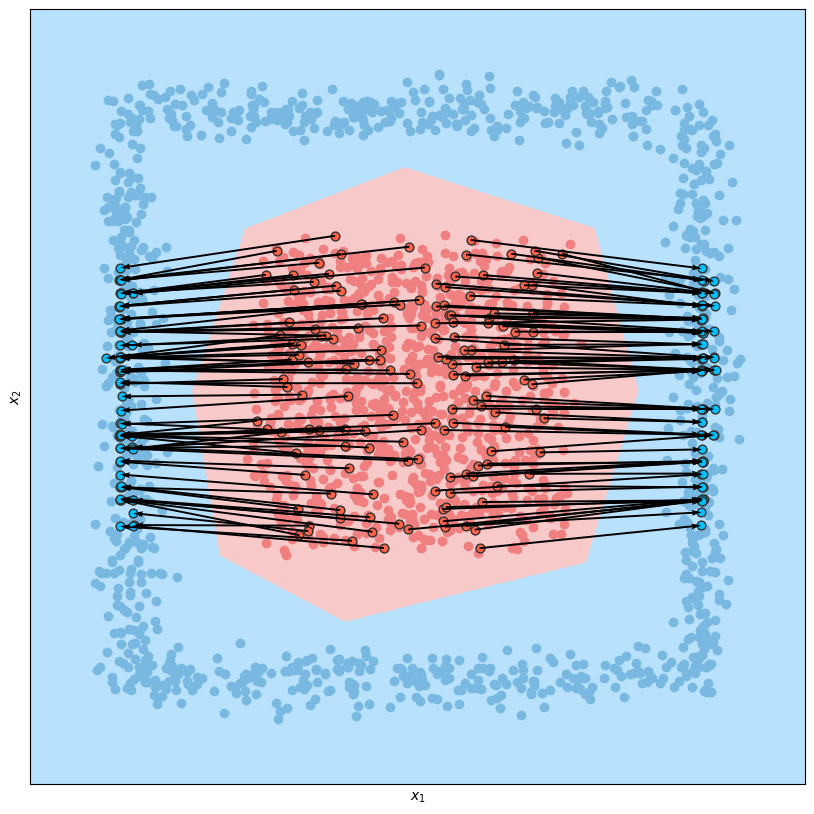

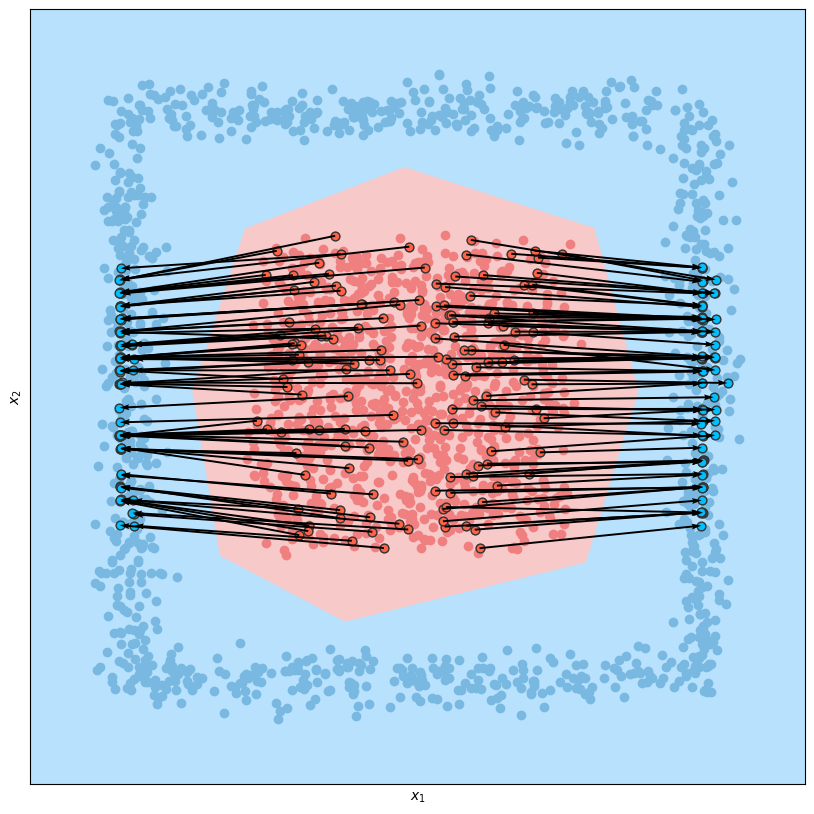

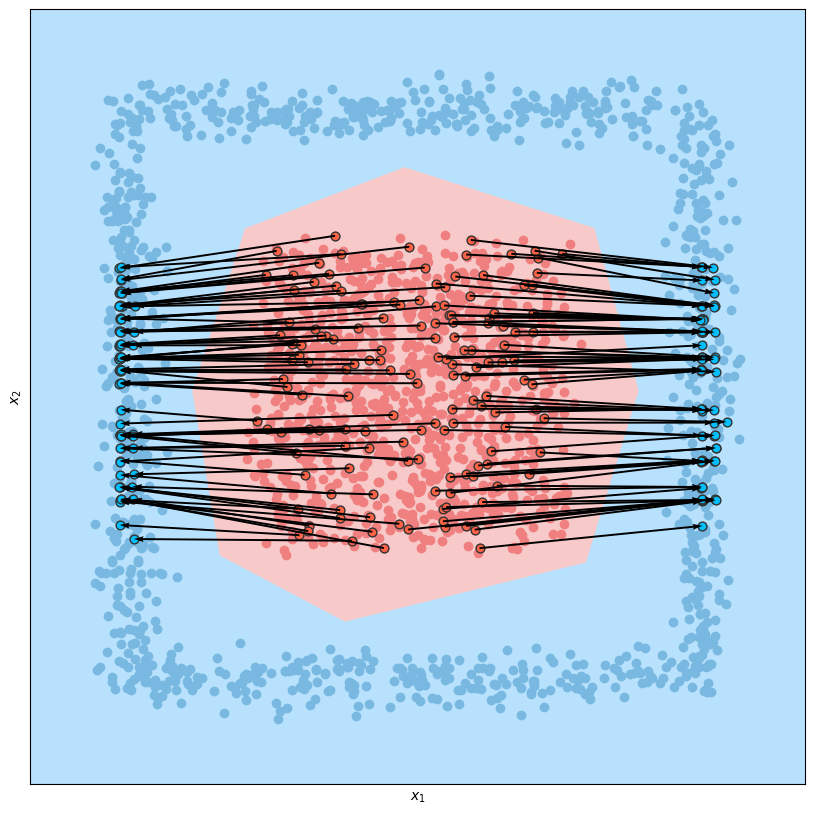

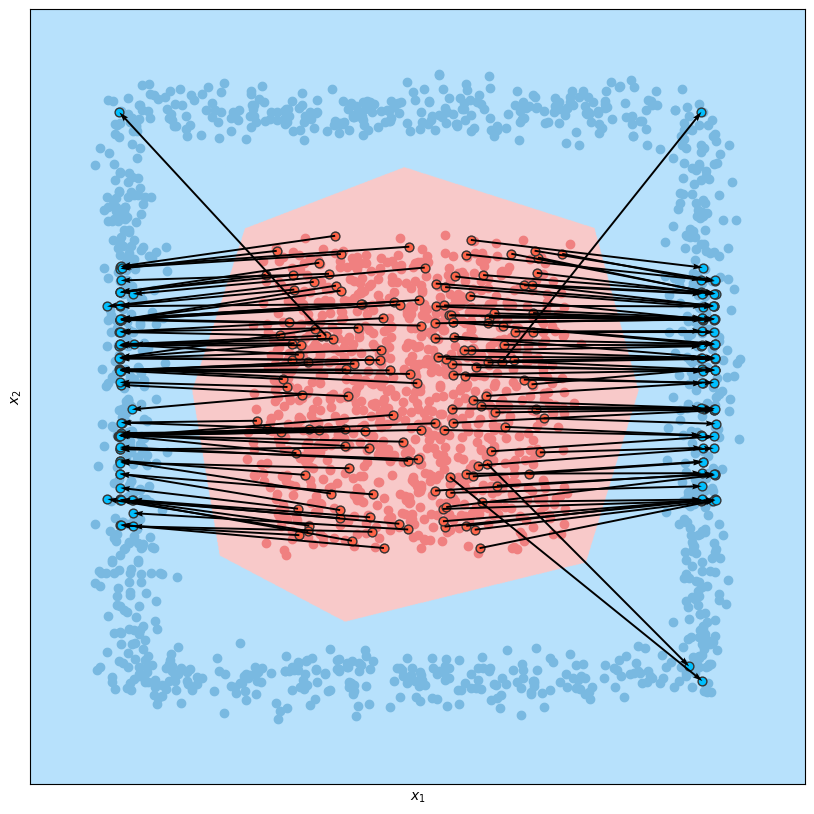

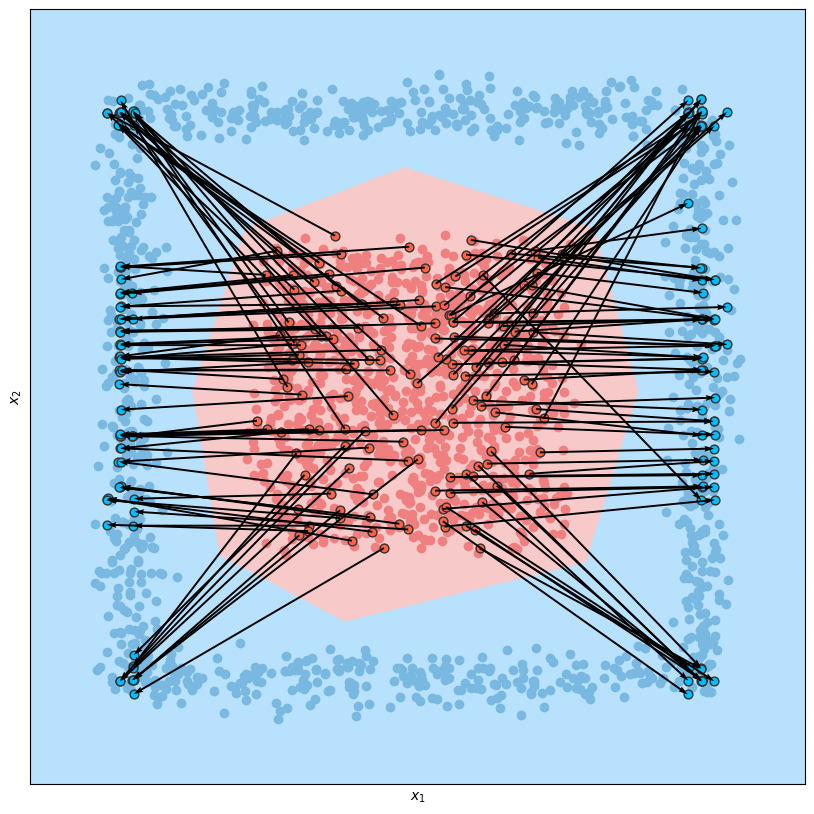

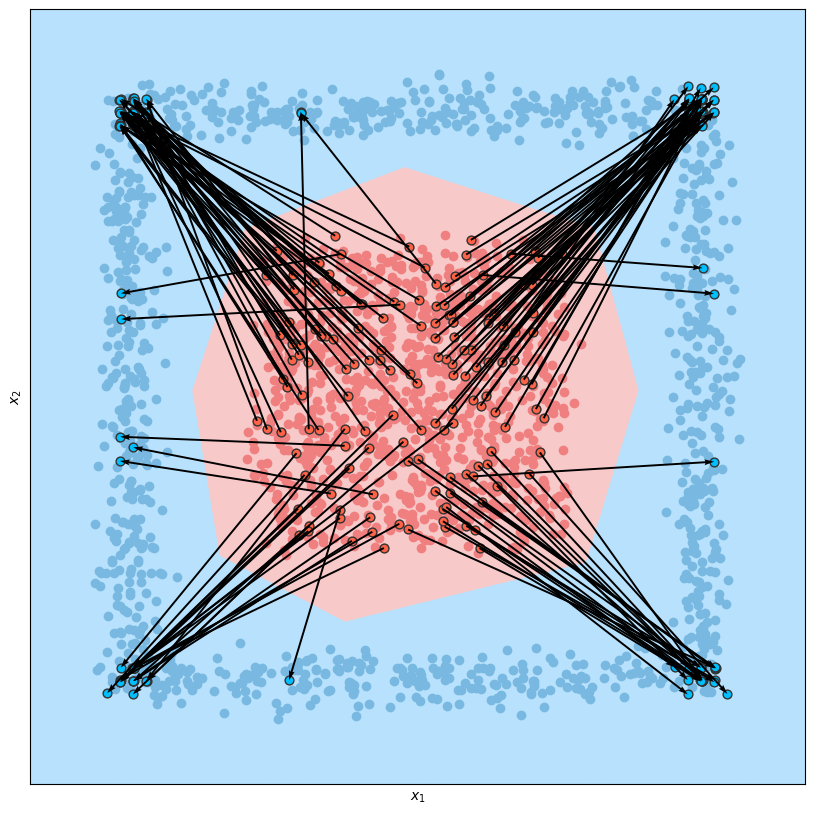

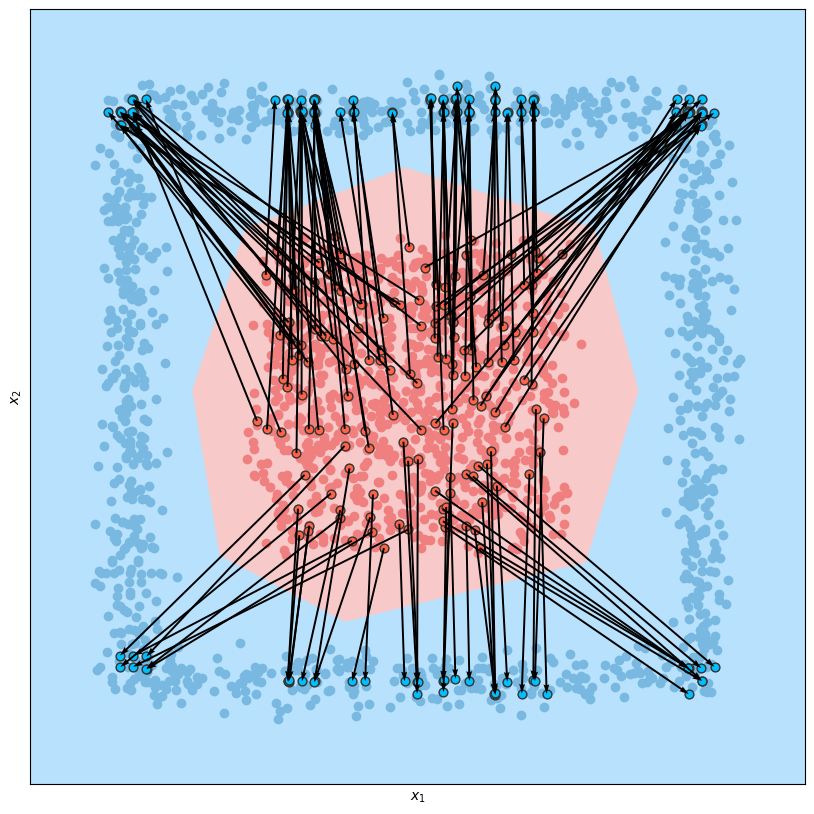

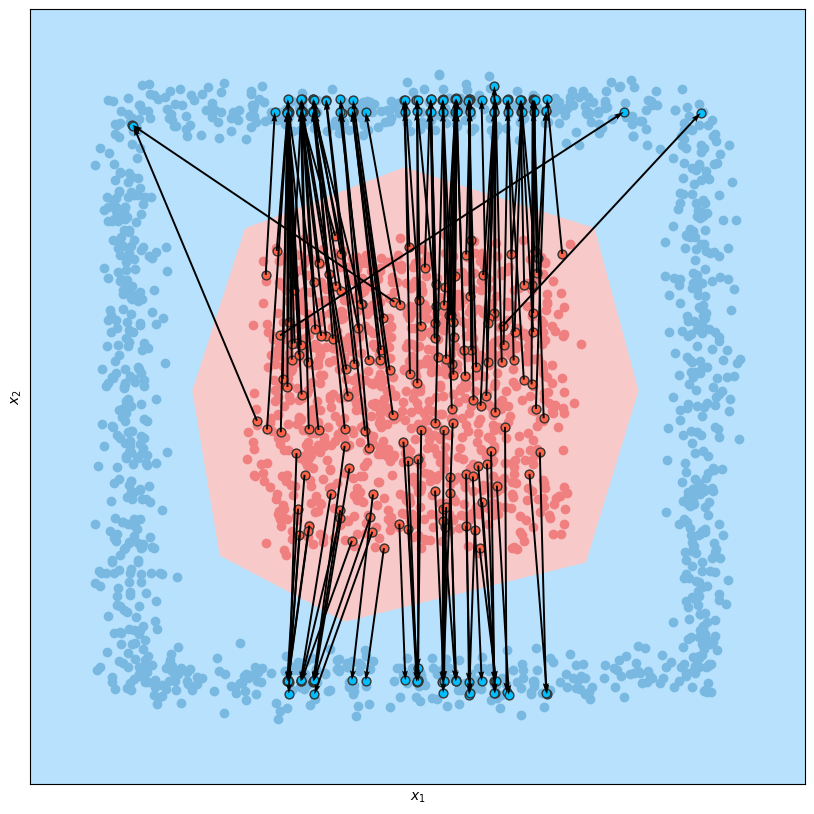

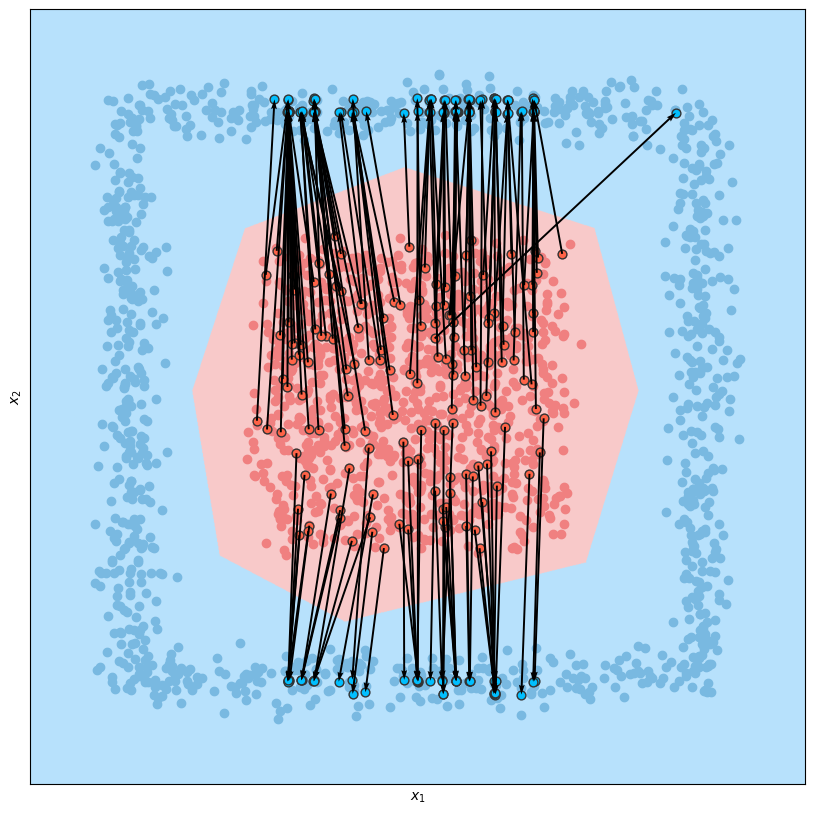

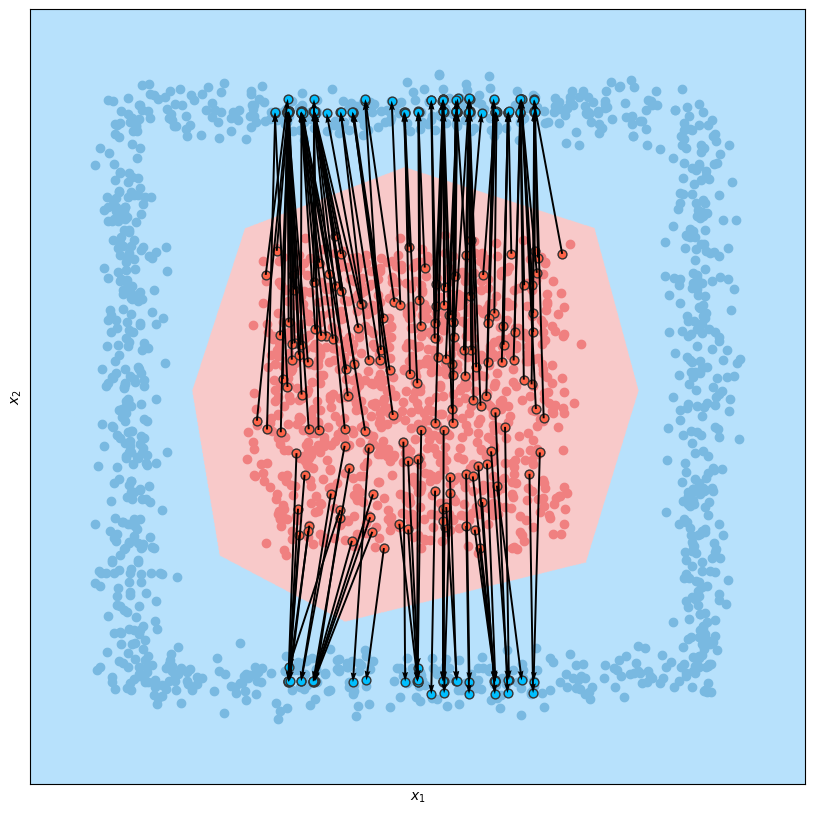

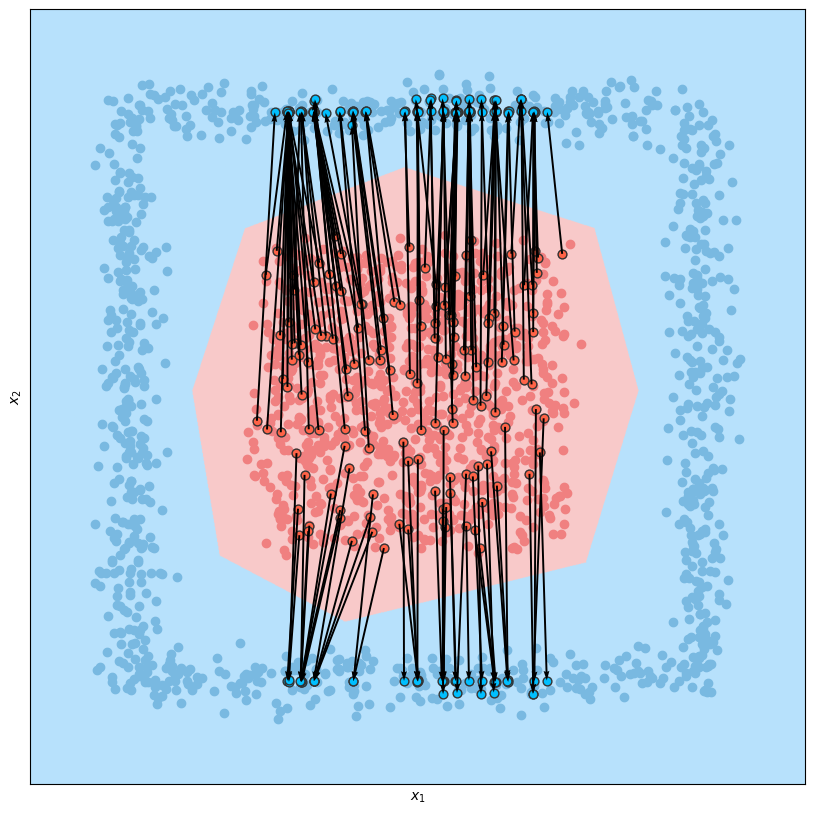

In [17]:
# xf_r = rutils.get_neg_inst(ann_clf,train_X,YSTAR,sample=150)
# xf_r = xf_r.to(DEVICE)

flexi_rec_module = OldFlexibleGenRe(pair_models=[pair_model_1, pair_model_2], temp=10, sigma=0.001, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
all_scores = []
all_weights = []
train_lambda = 75.0
for weight_1 in np.arange(0, 1.1, 0.1):
    cost_weights = [float(weight_1), 1.0-float(weight_1)]
    cost_weights_str = f"{cost_weights[0]:.1f}_{cost_weights[1]:.1f}"
    
    flexi_sample_xcf = flexi_rec_module(xf_r, cost_weights, gamma=1e-7)

    final_score = get_score(xf_r, flexi_sample_xcf, immutable_mask, ann_clf, cost_weights=cost_weights, lambda_=train_lambda, p=TRAIN_P, gamma=0.7)
    all_weights.append(cost_weights)
    all_scores.append(final_score.item())
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 20))
    
    utils.viz_clf(ax,ann_clf,train_X,train_y,hard=True)
    utils.scatter2d(ax,train_X,train_y,data_name='training data', s=20, show_axis_name=False)
    utils.plot_pairs(ax,xf_r,flexi_sample_xcf,None,arrows=True, names=('negative instances',"recourse instances"), s=40, edgecolor = "#333",show_axis_name=False)
    PM_OUTDIR = f'./results/old_flexible_genre/{DATASET_STR}_gamma0.7'
    os.makedirs(PM_OUTDIR, exist_ok=True)
    plt.savefig(f"{PM_OUTDIR}/plot_{train_lambda}_{cost_weights_str}.png")
    # plt.show()

[1.9808284044265747, 1.9480232000350952, 1.9149260520935059, 1.8754643201828003, 1.7808079719543457, 1.6737223863601685, 1.781288981437683, 1.8769646883010864, 1.9135054349899292, 1.946479082107544, 1.979319453239441]


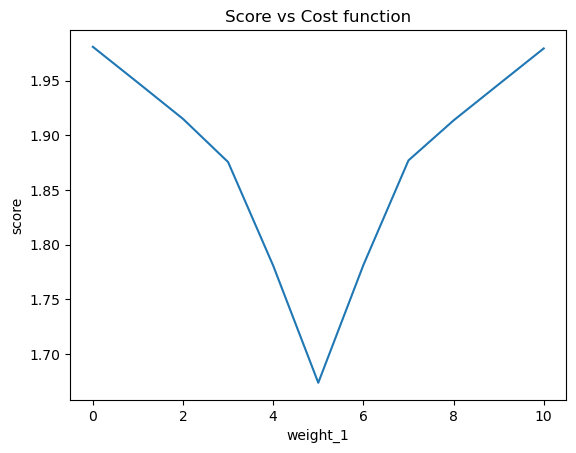

In [18]:
plt.plot(all_scores)
print(all_scores)
plt.xlabel('weight_1')
plt.ylabel('score')
plt.title('Score vs Cost function')
plt.savefig(f"{PM_OUTDIR}/plot_{train_lambda}_score_vs_cost.png")

In [19]:
circles_75_old = [1.9330315589904785, 1.9238200187683105, 1.9131152629852295, 1.902999758720398, 1.889527678489685, 1.8764560222625732, 1.8885964155197144, 1.9064807891845703, 1.918625831604004, 1.932174563407898, 1.944899320602417]
squares_75_old = [1.9808284044265747, 1.9480232000350952, 1.9149260520935059, 1.8754643201828003, 1.7808079719543457, 1.6737223863601685, 1.781288981437683, 1.8769646883010864, 1.9135054349899292, 1.946479082107544, 1.979319453239441]
